# Lossless JPEG Experimentation

Question: how effective is JPEG-LS at compressing our 1 second exposures? 

This notebook compares the effectiveness of JPEG-LS compared to JPEG and JPEG-2000 for several simple parameterizations.
The relevant metric here is just the ratio of the file size between the JPEG-LS files compared to other formats.

In [330]:
import pathlib
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
import astropy.units as u

import PIL
import pillow_jpls

from overlappy.util import color_lat_lon_axes
from mocksipipeline.util import stack_components

In [435]:
def compare_jpeg_ls_compression(array, compare_format='JPEG2000', mode='I;16'):
    pil_image = PIL.Image.fromarray(array.astype(np.uint16)).convert(mode=mode)
    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir_p = pathlib.Path(tmpdir)
        jpls_path = tmpdir_p / 'image.jls'
        jp_path = tmpdir_p / 'image.jpg'
        pil_image.save(jpls_path, format='JPEG-LS')
        jpeg_ls_size = jpls_path.stat().st_size * u.byte
        print('JPEG-LS size: ',jpeg_ls_size.to('kilobyte'))
        if compare_format is None:
            other_size = np.product(array.shape) * 16 * u.bit
        else:
            pil_image.save(jp_path, format=compare_format)
            other_size = jp_path.stat().st_size * u.byte
        print('Other size: ',other_size.to('kilobyte'))
        ratio = other_size / jpeg_ls_size
        
    return ratio.decompose()

In [390]:
data_dir = pathlib.Path('data/')

In [391]:
files = data_dir.glob('overlappogram-ar-photons-order=*.fits')

In [392]:
overlappogram = stack_components(sorted(files), wcs_index=2)

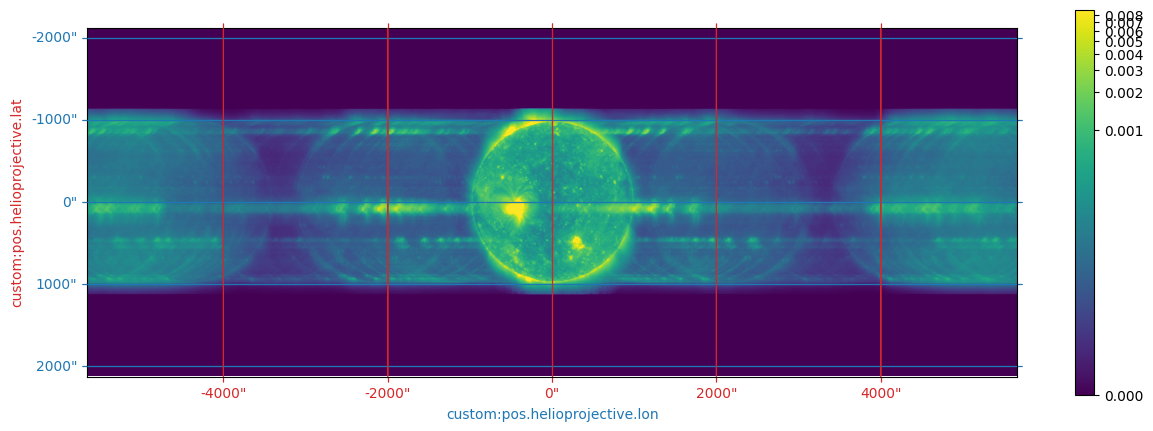

In [393]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(overlappogram[0].data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=overlappogram[0].wcs)
overlappogram[0].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

## Everything is 1

In [394]:
overlappogram_ones = np.ones(overlappogram.data[0].shape)

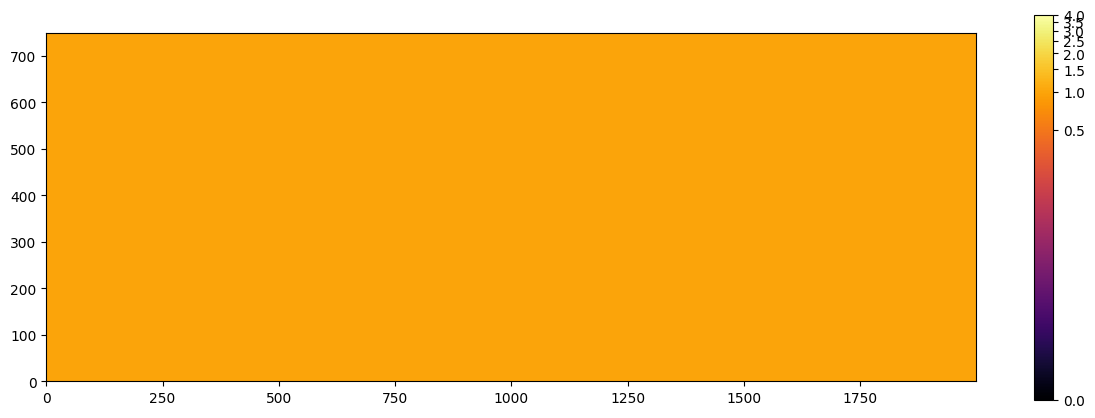

In [395]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_ones,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [436]:
compare_jpeg_ls_compression(overlappogram_ones, compare_format='JPEG', mode='L')

JPEG-LS size:  0.443 kbyte
Other size:  17.957 kbyte


<Quantity 40.53498871>

In [437]:
compare_jpeg_ls_compression(overlappogram_ones, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  0.544 kbyte
Other size:  0.23700000000000002 kbyte


<Quantity 0.43566176>

In [438]:
compare_jpeg_ls_compression(overlappogram_ones, compare_format=None, mode='I;16')

JPEG-LS size:  0.544 kbyte
Other size:  3000.0 kbyte


<Quantity 5514.70588235>

## Everything is 0

In [399]:
overlappogram_zeros = np.zeros(overlappogram.data[0].shape)

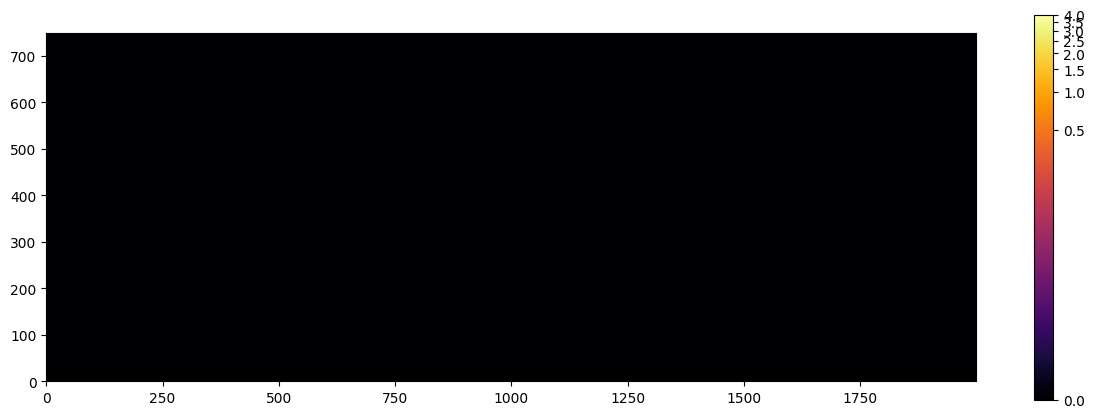

In [400]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_zeros,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [439]:
compare_jpeg_ls_compression(overlappogram_zeros, compare_format='JPEG', mode='L')

JPEG-LS size:  0.17500000000000002 kbyte
Other size:  17.957 kbyte


<Quantity 102.61142857>

In [440]:
compare_jpeg_ls_compression(overlappogram_zeros, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  0.19 kbyte
Other size:  0.23800000000000002 kbyte


<Quantity 1.25263158>

In [441]:
compare_jpeg_ls_compression(overlappogram_zeros, compare_format=None, mode='I;16')

JPEG-LS size:  0.19 kbyte
Other size:  3000.0 kbyte


<Quantity 15789.47368421>

## Random Counts

Random distribution of counts over the detector

In [404]:
overlappogram_random = np.random.randint(0, high=5, size=overlappogram.data[0].shape, dtype=np.uint16)

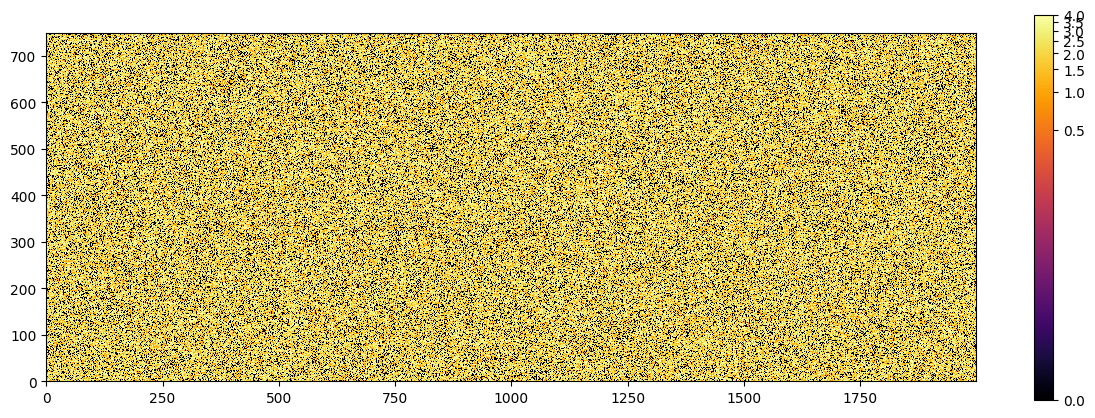

In [405]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_random,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [442]:
compare_jpeg_ls_compression(overlappogram_random, compare_format='JPEG', mode='L')

JPEG-LS size:  538.343 kbyte
Other size:  23.185 kbyte


<Quantity 0.04306734>

In [443]:
compare_jpeg_ls_compression(overlappogram_random, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  546.984 kbyte
Other size:  535.896 kbyte


<Quantity 0.97972884>

In [444]:
compare_jpeg_ls_compression(overlappogram_random, compare_format=None, mode='I;16')

JPEG-LS size:  546.984 kbyte
Other size:  3000.0 kbyte


<Quantity 5.48462112>

## Thresholding non-zero values

This just makes everything over some threshold value 1 and everything else 0

In [409]:
overlappogram_bool = (overlappogram.data[0] > 0.001).astype(np.uint16)

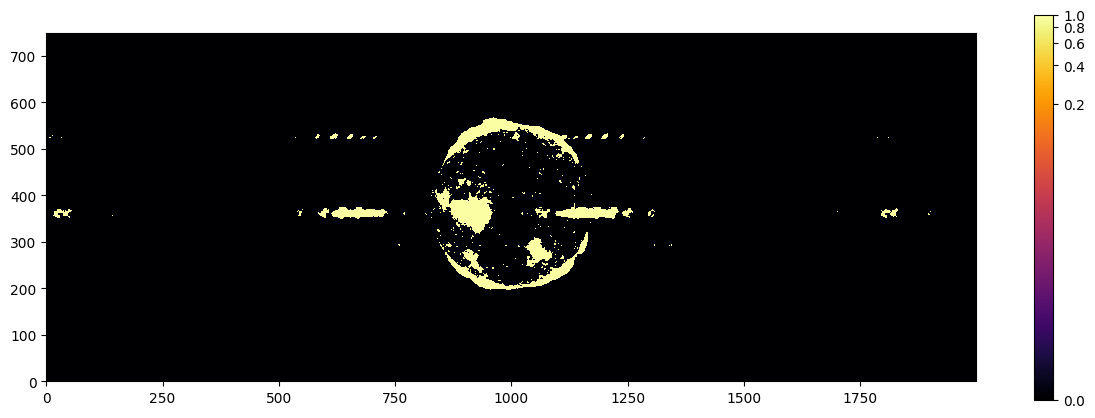

In [410]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_bool)
plt.imshow(overlappogram_bool,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [445]:
compare_jpeg_ls_compression(overlappogram_bool, compare_format='JPEG', mode='L')

JPEG-LS size:  5.287 kbyte
Other size:  18.046 kbyte


<Quantity 3.41327785>

In [446]:
compare_jpeg_ls_compression(overlappogram_bool, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  6.008 kbyte
Other size:  7.162 kbyte


<Quantity 1.19207723>

In [447]:
compare_jpeg_ls_compression(overlappogram_bool, compare_format=None, mode='I;16')

JPEG-LS size:  6.008 kbyte
Other size:  3000.0 kbyte


<Quantity 499.33422104>

## Sampling from a Poisson Distribution 

Use the simulated image create a Poisson distribution for each pixel.

In [448]:
dt = 1 * u.s

In [449]:
probability_rate = overlappogram[0].data * overlappogram.unit * u.pix

In [450]:
counts = np.random.poisson(lam=(probability_rate*dt).to_value('photon'))

In [451]:
counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

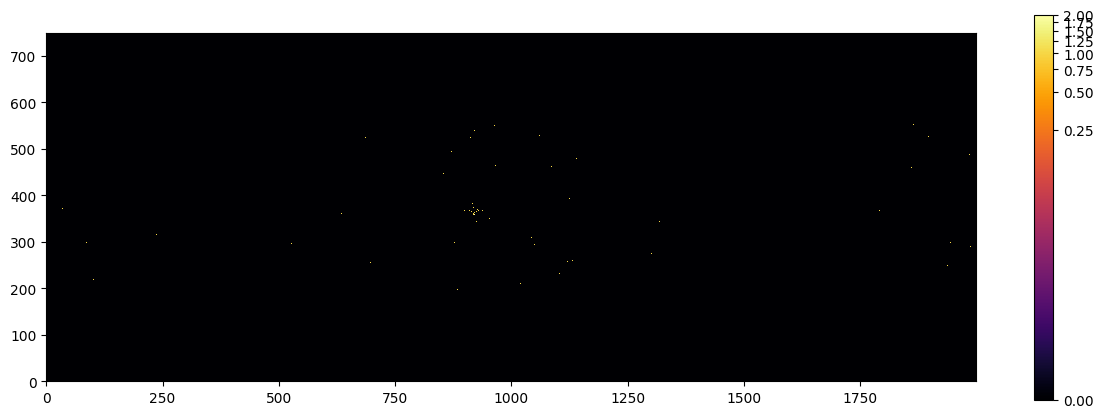

In [452]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(counts)
plt.imshow(counts,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [453]:
compare_jpeg_ls_compression(counts, compare_format='JPEG', mode='L')

JPEG-LS size:  0.589 kbyte
Other size:  17.957 kbyte


<Quantity 30.48726655>

In [454]:
compare_jpeg_ls_compression(counts, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  0.81 kbyte
Other size:  1.0110000000000001 kbyte


<Quantity 1.24814815>

In [455]:
compare_jpeg_ls_compression(counts, compare_format=None, mode='I;16')

JPEG-LS size:  0.81 kbyte
Other size:  3000.0 kbyte


<Quantity 3703.7037037>

## Scaling Up the Overlappogram Image

In [456]:
scaling_factor = 1 / overlappogram.data[0][np.nonzero(overlappogram.data[0])].min()

In [457]:
overlappogram_scaled = (overlappogram.data[0] * scaling_factor).astype(np.uint16)

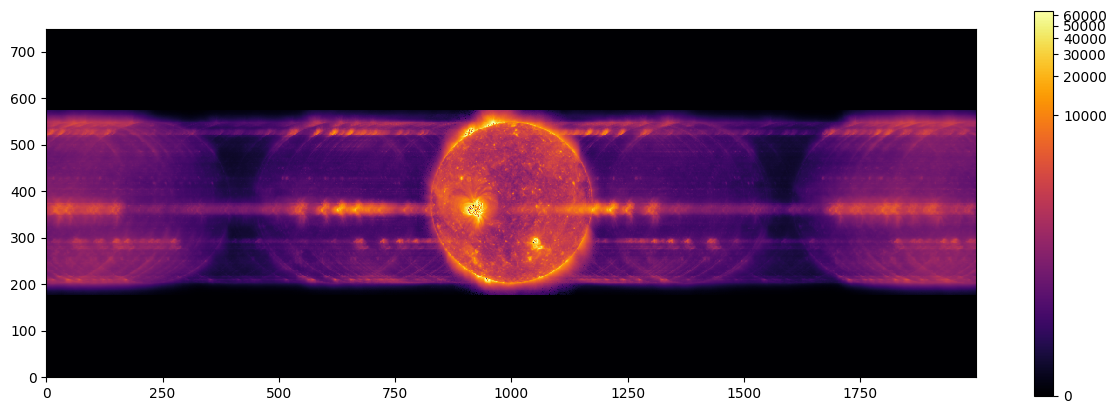

In [458]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_scaled)
plt.imshow(overlappogram_scaled,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [459]:
compare_jpeg_ls_compression(overlappogram_scaled, compare_format='JPEG', mode='L')

JPEG-LS size:  148.861 kbyte
Other size:  63.115 kbyte


<Quantity 0.42398613>

In [460]:
compare_jpeg_ls_compression(overlappogram_scaled, compare_format='JPEG2000', mode='I;16')

JPEG-LS size:  601.905 kbyte
Other size:  607.489 kbyte


<Quantity 1.00927721>

In [461]:
compare_jpeg_ls_compression(overlappogram_scaled, compare_format=None, mode='I;16')

JPEG-LS size:  601.905 kbyte
Other size:  3000.0 kbyte


<Quantity 4.98417524>

## Conclusions

- JPEG2000 and JPEG-LS provide similar compression in nearly all cases
- JPEG-LS provides marginally better performance (factor of $\approx1.2$) than JPEG2000 for Poisson sampling case
- The noiser the image, the worse JPEG-LS does compared to normal JPEG--see uniform distribution case above
- The more areas of continuous tone the better the performance
- More zeros perform better than more non-zeros
- JPEG-LS provides a factor of $\approx30$ better compression than JPEG for most realistic case of Poisson sampling
- The more photons we have, the worse JPEG-LS will do